En este Nootebock se realiza la limpieza del conjunto train, de tal manera, que al terminar la pipeline ya se puede emplear dicho conjunto para el entrenamiento de modelos.

Se expondrá en un pequeño comentario en la parte superior por la razon que se realiza el cambio

Para una mejor descripción se puede consultar *PreprocesadoTrainRaw.ipynb* donde se comentan un poco mejor los pasos realizados.

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

df = pd.read_table('Modelar_UH2019.txt', sep = '|', dtype={'HY_cod_postal':str})

In [181]:
df = pd.read_table('Modelar_UH2019.txt', sep = '|', dtype={'HY_cod_postal':str})
# Tenemos varios Nans en HY_provincias, por lo que creamos la siguiente función que nos ayudará a imputarlos con
#     ayuda del código postal
def ArreglarProvincias(df):
    # Diccionario de los códigos postales. 'xxddd' --> xx es el código asociado a la provincia
    diccionario_postal = {'02':'Albacete','03':'Alicante','04':'Almería','01':'Álava','33':'Asturias',
                          '05':'Avila','06':'Badajoz','07':'Baleares', '08':'Barcelona','48':'Bizkaia',
                          '09':'Burgos','10':'Cáceres','11':'Cádiz','39':'Cantabria','12':'Castellón',
                          '13':'Ciudad Real','14':'Córdoba','15':'A Coruña','16':'Cuenca','20':'Gipuzkoa',
                          '17':'Gerona','18':'Granada','19':'Guadalajara','21':'Huelva','22':'Huesca',
                          '23':'Jaén','24':'León','25':'Lérida','27':'Lugo','28':'Madrid','29':'Málaga',
                          '30':'Murcia','31':'Navarra','32':'Ourense','34':'Palencia','35':'Las Palmas',
                          '36':'Pontevedra','26':'La Rioja','37':'Salamanca','38':'Tenerife','40':'Segovia',
                          '41':'Sevilla','42':'Soria','43':'Tarragona','44':'Teruel','45':'Toledo','46':'Valencia',
                          '47':'Valladolid','49':'Zamora','50':'Zaragoza','51':'Ceuta','52':'Melilla'}
    
    # Obtenemos los códigos postales que nos faltan
    codigos_postales = df.loc[df.HY_provincia.isnull()].HY_cod_postal
    
    # Recorremos la pareja index, value
    for idx, cod in zip(codigos_postales.index, codigos_postales):
        # Del cod solo nos interesan los dos primeros valores para la provincia.
        df.loc[idx,'HY_provincia'] = diccionario_postal[cod[:2]]
        
    # Devolvemos el df de las provincias
    return df

# Obtenemos nuestro df con las provincias imputadas
df = ArreglarProvincias(df)


########## Metros ##############
# Volvemos Nans los valores de 0m^2 o inferior --> Los 0 provocan errores en una nueva variable de €/m2
df.loc[df['HY_metros_utiles'] <= 0,'HY_metros_utiles'] = np.nan
df.loc[df['HY_metros_totales'] <= 0,'HY_metros_totales'] = np.nan

# Obtenemos las posiciones de los valores faltantes een los metros útiles
posiciones_nans = df['HY_metros_totales'].isnull()

# Rellenamos los Nans con los metros totales
df.loc[posiciones_nans,'HY_metros_totales'] = df.loc[posiciones_nans,'HY_metros_utiles']

# Obtenemos las posiciones de los valores faltantes een los metros útiles
posiciones_nans = df['HY_metros_utiles'].isnull()

# Rellenamos los Nans con los metros totales
df.loc[posiciones_nans,'HY_metros_utiles'] = df.loc[posiciones_nans,'HY_metros_totales']

# Si continuamos teniendo Nans
if df[['HY_metros_utiles', 'HY_metros_totales']].isnull().sum().sum()>0: # Hay 2 .sum para sumarlo todo
    # Agrupamos por HY_tipo
    group_tipo = df[['HY_tipo', 'HY_metros_utiles', 'HY_metros_totales']].dropna().groupby('HY_tipo').mean()
    # Cuales son los indices de los registros que tienen nans
    index_nans = df.index[df['HY_metros_utiles'].isnull()]
    for i in index_nans:
        tipo = df.loc[i, 'HY_tipo']
        df.loc[i, ['HY_metros_utiles', 'HY_metros_totales']] = group_tipo.loc[tipo]
        
# Eliminamos los outliers
# Definimos la cota a partir de la cual son outliers
cota = df['HY_metros_utiles'].mean()+3*df['HY_metros_utiles'].std()
# Y nos quedamos con todos aquellos que no la superan
df = df[df['HY_metros_utiles'] <= cota]
# Idem para metros totales
# Definimos la cota a partir de la cual son outliers
cota = df['HY_metros_totales'].mean()+3*df['HY_metros_totales'].std()
# Y nos quedamos con todos aquellos que no la superan
df = df[df['HY_metros_totales'] <= cota]

# Por último, eliminamos los registros que presenten una diferencia excesiva de metros
dif_metros = np.abs(df.HY_metros_utiles - df.HY_metros_totales)
df = df[dif_metros <= 500]

########## Precios ############
# Creamos una nueva variable que sea ¿Existe precio anterior?--> Si/No
df['PV_precio_anterior'] = df['HY_precio_anterior'].isnull()
# Y modificamos precio anterior para que tenga los valores del precio actual como anterior
df.loc[df['HY_precio_anterior'].isnull(),'HY_precio_anterior'] = df.loc[df['HY_precio_anterior'].isnull(),'HY_precio']
# Eliminamos también los precios irrisorios (Todos aquellos precios inferiores a 100€)
v = df[['HY_precio', 'HY_precio_anterior']].apply(lambda x: x[0] <= 100 and x[1] <= 100, axis = 1)
df = df[v == False]



######## Descripción y distribución #########
# Creamos 2 nuevas variables con la longitud del texto expuesto (Nan = 0)
# Igualamos los NaN a carácteres vacíos
df.loc[df['HY_descripcion'].isnull(),'HY_descripcion'] = ''
df.loc[df['HY_distribucion'].isnull(),'HY_distribucion'] = ''
# Calculamos su longitud
df['PV_longitud_descripcion'] = df['HY_descripcion'].apply(lambda x: len(x))
df['PV_longitud_distribucion'] = df['HY_distribucion'].apply(lambda x: len(x))

####### Cantidad de imágenes #########
# Añadimos una nueva columna que es la cantidad de imágenes que tiene asociado el piso
# El df de información de las imágenes tiene 3 columnas: id, posicion_foto, carácteres_aleatorios
df_imagenes = pd.read_csv('df_info_imagenes.csv', sep = '|',encoding = 'utf-8')
# Realizamos un count de los ids de las imagenes (Y nos quedamos con el valor de la 
#      variable Posiciones (Al ser un count, nos es indiferente la variable seleccionada))
df_count_imagenes = df_imagenes.groupby('HY_id').count()['Posiciones']
# Definimos la función que asocia a cada id su número de imágenes
def AñadirCantidadImagenes(x):
    try:
        return df_count_imagenes.loc[x]
    except:
        return 0
# Creamos la variable
df['PV_cantidad_imagenes'] = df['HY_id'].apply(lambda x: AñadirCantidadImagenes(x))


######### Imputación de las variables IDEA #########
# En el notebook ImputacionNans.ipynb se explica en mayor profundidad las funciones definidas. Por el momento, 
#    para imputar los valores Nans de las variables IDEA realizamos lo siguiente:
#       -1. Hacemos la media de las variables que no son Nan por CP
#       -2. Imputamos por la media del CP
#       -3. Repetimos para aquellos codigos postales que son todo Nans con la media por provincias (Sin contar los imputados)
#       -4. Imputamos los Nans que faltan por la media general de todo (Sin contar los imputados)
var_list = [
    ['IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89','IDEA_pc_1990_99', 'IDEA_pc_2000_10'],
    ['IDEA_pc_comercio','IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros','IDEA_pc_residencial', 'IDEA_pc_trast_parking'],
    ['IDEA_ind_tienda', 'IDEA_ind_turismo', 'IDEA_ind_alimentacion'],
    ['IDEA_ind_riqueza'],
    ['IDEA_rent_alquiler'],
    ['IDEA_ind_elasticidad', 'IDEA_ind_liquidez'],
    ['IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential', 'IDEA_stock_sale_residential'],
    ['IDEA_demand_sale_residential'],
    ['IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential', 'IDEA_stock_rent_residential'],
    ['IDEA_demand_rent_residential']   
]
# Función que imputa Nans por la media de CP o Provincias (La versión de ImputacionNans.ipynb imprime el número
#    de valores faltantes después de la imputación)
def ImputarNans_cp(df, vars_imput, var): 
    '''
    df --> Nuestro dataframe a modificar
    vars_imput --> Variables que queremos imputar.
    var --> Variable por la que queremos realizar la agrupación (HY_cod_postal ó HY_provincia)
    '''
    # Obtenemos nuestros df de grupos
    group_cp = df[[var]+vars_imput].dropna().groupby(var).mean()
    
    # Obtenemos los CP que son Nans
    codigos_nans = df.loc[df[vars_imput[0]].isnull(), var] # Valdría cualquiera de las 6 variables.
    
    # Como sabemos que códigos podremos completar y cuales no, solo utilizaremos los que se pueden completar
    cods = np.intersect1d(codigos_nans.unique(),group_cp.index)
    # Cuales son los índices de los Nans
    index_nan = df.index[df[vars_imput[0]].isnull()]
    for cod in cods:
        # Explicación del indexado: De todos los códigos que coinciden con el nuestro nos quedamos con los que tienen índice
        #      nan, y para poder acceder a df, necesitamos los índices de Nan que cumplen lo del código.
        i = index_nan[(df[var] == cod)[index_nan]]
        df.loc[i, vars_imput] = group_cp.loc[cod].values
    
    # Devolvemos los dataframes
    return df, group_cp
# Bucle que va variable por variable imputando los valores
for vars_group in var_list:
    #print('*'*50)
    #print('Variables:', vars_group)
    #print('-'*10+' CP '+'-'*10)
    df, group_cp = ImputarNans_cp(df, vars_group, var = 'HY_cod_postal')
    #print('-'*10+' Provincias '+'-'*10)
    df, group_provincia = ImputarNans_cp(df, vars_group, var = 'HY_provincia')
    
    # Si aún quedan Nans los ponemos a todos con la media de todo
    registros_faltantes = df[vars_group[0]].isnull().sum()
    if registros_faltantes>0:
        #print('-'*30)
        df.loc[df[vars_group[0]].isnull(), vars_group] = group_provincia.mean(axis = 0).values
        #print('Se han imputado {} registros por la media de todo'.format(registros_faltantes))
    # Guardamos los datos en la carpeta DF_grupos ya que tenemos que imputar en test por estos mismos valores.
    df.to_csv('./DF_grupos/df_filled_{}.csv'.format(vars_group[0]), sep = '|', encoding='utf-8', index = False)
    group_cp.to_csv('./DF_grupos/group_cp_{}.csv'.format(vars_group[0]), sep = '|', encoding='utf-8')
    group_provincia.to_csv('./DF_grupos/group_prov_{}.csv'.format(vars_group[0]), sep = '|', encoding='utf-8')

####### Indice elasticidad ##########
# Creamos una nueva variable que redondea el indice de elasticidad al entero más cercano (La variable toma 1,2,3,4,5)
df['PV_ind_elasticidad'] = np.round(df['IDEA_ind_elasticidad'])

###### Antigüedad zona #########
# Definimos la variable de antigüedad de la zona dependiendo del porcentaje de pisos construidos en la zona
# Primero tomaremos las variables [IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,
#          IDEA_pc_1990_99,IDEA_pc_2000_10] y las transformaremos en solo 3. Y luego nos quedaremos 
#          con el máximo de esas tres para determinar el estado de la zona.
df['Viejos'] = df[['IDEA_pc_1960', 'IDEA_pc_1960_69']].sum(axis = 1)
df['Medios'] = df[['IDEA_pc_1970_79', 'IDEA_pc_1980_89']].sum(axis = 1)
df['Nuevos'] = df[['IDEA_pc_1990_99', 'IDEA_pc_2000_10']].sum(axis = 1)
df['PV_clase_piso'] = df[['Viejos','Medios','Nuevos']].idxmax(axis = 1)

# Añadimos una nueva variable que es si la longitud de la descripción es nula, va de 0 a 1000 carácteres, ó supera los 1000
df['PV_longitud_descripcion2'] = pd.cut(df['PV_longitud_descripcion'], bins = [-1,0,1000, np.inf], labels=['Ninguna', 'Media', 'Larga'], include_lowest=False)

# Precio de euro el metro
df['PV_precio_metro'] = df.HY_precio/df.HY_metros_totales

# Cambiamos Provincias por 'Castellón','Murcia','Almería','Valencia','Otros'
def estructurar_provincias(x):
    '''
    Funcion que asocia a x (Nombre de provincia) su clase
    '''
    # Lista de clases que nos queremos quedar
    if x in ['Castellón','Murcia','Almería','Valencia']:
        return x
    else:
        return 'Otros'
df['PV_provincia'] = df.HY_provincia.apply(lambda x: estructurar_provincias(x))

# Una nueva que es si el  inmueble presenta alguna distribución
df.loc[df['PV_longitud_distribucion'] > 0,'PV_longitud_distribucion'] = 1

# Cambiamos certificado energetico a Si/No (1/0)
df['PV_cert_energ'] = df['HY_cert_energ'].apply(lambda x: np.sum(x != 'No'))

# Cambiamos las categorías de HY_tipo a solo 3: [Piso, Garaje, Otros]
def CategorizarHY_tipo(dato):
    if dato in ['Piso', 'Garaje']:
        return dato
    else:
        return 'Otros'
df['PV_tipo'] = df['HY_tipo'].apply(CategorizarHY_tipo)

# Cambiamos la variable Garaje a Tiene/No tiene (1/0)
df.loc[df['HY_num_garajes']>1,'HY_num_garajes'] = 1

# Cambiamos baños por 0, 1, +1 (No tiene, tiene 1, tiene mas de 1)
df['PV_num_banos'] = pd.cut(df['HY_num_banos'], [-1,0,1,np.inf], labels = [0,1,'+1'])

# Cambiamos Num terrazas a Si/No (1/0)
df.loc[df['HY_num_terrazas']>1, 'HY_num_terrazas'] = 1


# Definimos las variables a eliminar para definir nuestro conjunto X
drop_vars = ['HY_id', 'HY_cod_postal', 'HY_provincia', 'HY_descripcion',
             'HY_distribucion', 'HY_tipo', 'HY_antiguedad','HY_num_banos', 'HY_cert_energ',
             'HY_num_garajes', 'IDEA_pc_1960', 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad', 'IDEA_ind_elasticidad',
             'Viejos', 'Medios','Nuevos']
# Explicación:
# + 'HY_id', 'HY_cod_postal' --> Demasiadas categorías
# + 'HY_provincia' --> Ya tenemos PV_provincia que las agrupa
# + 'HY_descripcion','HY_distribucion' --> Tenemos sus longitudes
# + 'HY_tipo' --> Ya hemos creado PV_tipo
# + 'HY_cert_energ','HY_num_garajes'--> Ya tenemos las PV asociadas (valores con 0 1)
# + 'IDEA_pc_1960' --> Está duplicada
# + 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad' --> Demasiados Nans
# + 'IDEA_ind_elasticidad' --> Tenemos la variable equivalente en PV
# + 'Viejos', 'Medios','Nuevos' --> Ya tenemos PV_clase_piso
# + 'TARGET' --> Por motivos obvios no la queremos en X
X = df.copy().drop(drop_vars+['TARGET'],axis = 1)
y = df.TARGET.copy()

# Eliminamos los outliers de las siguientes variables
cont_vars = ['HY_metros_utiles', 'HY_metros_totales','GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult','PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro']
for var in cont_vars:
    cota = X[var].mean()+3*X[var].std()
    y = y[X[var]<=cota]
    X = X[X[var]<=cota]
# Y eliminamos los Outliers de nuestra variable respuesta
X = X[y <= y.mean()+3*y.std()]
y = y[y <= y.mean()+3*y.std()]
# Realizamos el logaritmo de nuestra variable respuesta (Nota: Sumamos 1 para evitar log(0))
y = np.log(y+1)


# Creamos las variables Dummy para las categóricas
dummy_vars = ['PV_provincia','PV_longitud_descripcion2',
              'PV_clase_piso','PV_tipo','PV_num_banos']
# Unimos nuestro conjunto con el de dummies
X = X.join(pd.get_dummies(X[dummy_vars]))
# Eliminamos las variables que ya son Dummies
X = X.drop(dummy_vars, axis=1)


############# PCA ####################
# Realizamos una PCA con las variables IDEA (Nota: soolo tomamos 1 componente porque nos explica el 99.95% de la varianza)
idea_vars_price = [
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']

pca_prices = PCA(n_components=1)
idea_pca_price = pca_prices.fit_transform(X[idea_vars_price])
X['PV_idea_pca_price'] = (idea_pca_price-idea_pca_price.min())/(idea_pca_price.max()-idea_pca_price.min())
# Realizamos una PCA con las variables IDEA (Nota: soolo tomamos 1 componente porque nos explica el 78% de la varianza)
idea_vars_pc = [
       'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez']

pca_pc = PCA(n_components=1)
idea_pca_pc = pca_pc.fit_transform(X[idea_vars_pc])
X['PV_idea_pca_pc'] = (idea_pca_pc-idea_pca_pc.min())/(idea_pca_pc.max()-idea_pca_pc.min())

# Nos quedamos con la información PCA de nuestras PV 
pca_PV = PCA(n_components=3)
PV_pca = pca_PV.fit_transform(X[['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1']])

X['PV_pca1'] = PV_pca[:, 0]
X['PV_pca2'] = PV_pca[:, 1]
X['PV_pca3'] = PV_pca[:, 2]

# Eliminamos los posibles outliers creados
pca_vars = ['PV_idea_pca_price', 'PV_idea_pca_pc','PV_pca1', 'PV_pca2', 'PV_pca3']
for var in pca_vars:
    cota = X[var].mean()+3*X[var].std()
    y = y[X[var]<=cota]
    X = X[X[var]<=cota]

X = X.drop([
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential',
       'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez', 'PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1'], axis = 1)

# Entrenamiento de modelos

Hemos entrenado una gran cantidad de modelos, incluso podríamos llegar a decir que más de 1000 (a base de bucles y funciones) para ver cual es el que más se ajusta a nuestro dataset. Y para no tenerlos nadando entre los cientos de pruebas que hemos reaalizado en los notebooks *Modelos2\_TestingsModelos.ipynb*, *Modelos3\_featureSelection.ipynb*, *Modelos4\_ForwardAndEnsemble.ipynb*

In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Métrica
from sklearn.metrics import median_absolute_error


models = {
    'DecisionTreeRegressor10':tree.DecisionTreeRegressor(max_depth = 10),
    'RandomForestRegressor20':RandomForestRegressor(max_depth=5, n_estimators = 20, random_state=0),
    'RandomForestRegressor50':RandomForestRegressor(max_depth=10, n_estimators = 50, random_state=0),
    'RandomForestRegressor100':RandomForestRegressor(max_depth=10, n_estimators = 100, random_state=0),
    'ExtraTreesRegressor10':ExtraTreesRegressor(n_estimators=10,random_state=0),
    'ExtraTreesRegressor100':ExtraTreesRegressor(n_estimators=100, random_state=0),
    'ExtraTreesRegressor150':ExtraTreesRegressor(n_estimators=150, random_state=0),
    'GradientBoostingRegressor30_md5':GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=5, random_state=0, loss='ls'),
    'GradientBoostingRegressor50_md5':GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=0, loss='ls'),
    'XGB25':XGBRegressor(max_depth = 10, n_estimators=25, random_state=7),
    'XGB46':XGBRegressor(max_depth = 10, n_estimators=46, random_state=7),
    'XGB60':XGBRegressor(max_depth = 10, n_estimators=60, random_state=7),
    'XGB100':XGBRegressor(max_depth = 10, n_estimators=100, random_state=7)
    }

def EntrenarModelos(X, y, models, drop_vars):
    '''
    X, y --> Nuestra data
    models --> Diccionario de modelos a entrenar
    drop_vars --> Variables que no queremos en nuestro modelo
    '''
    X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_vars, axis = 1), y, test_size=0.3, random_state=7)
    
    y_test_predict = {}
    errores = {}
    # Definimos el diccionario donde vamos guardando el mejor modelo con su error asociado
    minimo = {'':np.inf}
    for name, model in models.items():
        #try:
        model = model.fit(X_train, y_train)
        y_test_predict[name] = model.predict(X_test)
        errores[name] = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict[name])-1)
        
        print(name,': ', errores[name], sep = '')
        
        # Actualizamos el diccionario
        if list(minimo.values())[0]  > errores[name]:
            minimo = {name:errores[name]}
    return minimo

EntrenarModelos(X, y, models, [])

DecisionTreeRegressor10: 21.55431393653663
RandomForestRegressor20: 18.580995303598044
RandomForestRegressor50: 19.072373408609195
RandomForestRegressor100: 18.861664050362826
ExtraTreesRegressor10: 19.80307387148771
ExtraTreesRegressor100: 18.588761921652768
ExtraTreesRegressor150: 18.57115721270116
GradientBoostingRegressor30_md5: 19.084825961682014
GradientBoostingRegressor50_md5: 18.973164773235773
XGB25: 18.734364471435548
XGB46: 18.948498382568367
XGB60: 19.172454528808608
XGB100: 19.46763259887696


{'ExtraTreesRegressor150': 18.57115721270116}

Para la optimización de los parámetros implementamos un grid search manual con el que vamos variando los parámetros mediante bucles for. Nosotros encontramos el óptimo en *n_estimators= 30, reg_lambda* = 0.9, *subsample = 0.6*, *colsample_bytree = 0.7*

In [131]:
models = {'BestXGBoost' : XGBRegressor(max_depth = 10, 
                                       n_estimators= 30, 
                                       reg_lambda = 0.9,
                                       subsample = 0.6,
                                       colsample_bytree = 0.7,
                                       objective = 'reg:linear',
                                       random_state=7)
         }

In [132]:
EntrenarModelos(X, y, models, [])

BestXGBoost: 17.369460296630855


{'BestXGBoost': 17.369460296630855}

In [133]:
# Variable que indica si queremos iniciar la búsqueda
QuererBuscar = False

if QuererBuscar == True:
    models = {}
    for i1 in [30, 40, 46, 50, 60]:
        for i2 in [0.7, 0.8, 0.9, 1]:
            for i3 in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
                for i4 in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
                    models['XGB_{}_{}_{}_{}'.format(i1, i2, i3, i4)] = XGBRegressor(max_depth = 10, 
                                                                          n_estimators= i1, 
                                                                          reg_lambda = i2,
                                                                          subsample = i3,
                                                                          colsample_bytree = i4,
                                                                          objective = 'reg:linear',
                                                                          random_state=7)
    print(len(models))
    
else:
    models = {'BestXGBoost' : XGBRegressor(max_depth = 10, 
                                           n_estimators= 30, 
                                           reg_lambda = 0.9,
                                           subsample = 0.6,
                                           colsample_bytree = 0.7,
                                           objective = 'reg:linear',
                                           random_state=7)
             }
    
EntrenarModelos(X, y, models, [])

BestXGBoost: 17.369460296630855


{'BestXGBoost': 17.369460296630855}

Una vez definido el mejor modelo vamos a realizar una búsqueda de las mejores variables. Y para ello definimos una función forward que nos vaya añadiendo variables según su error.

In [134]:
def Entrenar(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    error = median_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1)
    
    return error

def EntrenarForward(X, y, model, ini_vars):
    '''
    X,y --> Nuestra data
    model --> un modelo
    ini_vars --> variables con las que comenzamos
    '''
    # Variable que indica si hemos terminado
    fin = False
    
    # Variables con las que estamos trabajando
    current_vars = ini_vars
    all_vars = X.columns
    possible_vars = np.setdiff1d(all_vars, current_vars)
    
    while not fin and len(possible_vars) > 0: # Lo que antes pase
        possible_vars = np.setdiff1d(all_vars, current_vars)
        
        if len(current_vars) == 0:
            # Si no tenemos variables, cuestro error es inf
            best_error = np.inf
        else:
            base_error = Entrenar(X[current_vars], y, model)
            best_error = base_error
        
        best_var = ''
        for var in possible_vars:
            var_error = Entrenar(X[current_vars+[var]],y,model)
            
            if var_error < best_error:
                best_error = var_error
                best_var = var
        
        print('Best var: {} --> {:.4f}'.format(best_var, best_error))
        # Si tenemos una best_var        
        if len(best_var) > 0:
            current_vars += [best_var]
        else: 
            fin = True
            
    print('Best vars:', current_vars)
    print('Best error:', best_error)
    
    return best_error

In [136]:
EntrenarForward(X, y, XGBRegressor(max_depth = 10, 
                                   n_estimators= 30, 
                                   reg_lambda = 0.9,
                                   subsample = 0.6,
                                   colsample_bytree = 0.7,
                                   objective = 'reg:linear',
                                   random_state=7), 
                [])

Best var: GA_page_views --> 18.9004
Best var: GA_mean_bounce --> 18.6871
Best var: IDEA_pc_1970_79 --> 18.4164
Best var: PV_pca2 --> 18.1765
Best var: PV_longitud_descripcion --> 18.1751
Best var:  --> 18.1751
Best vars: ['GA_page_views', 'GA_mean_bounce', 'IDEA_pc_1970_79', 'PV_pca2', 'PV_longitud_descripcion']
Best error: 18.17510498046875


18.17510498046875

In [135]:
EntrenarForward(X, y, XGBRegressor(max_depth = 10, 
                                   n_estimators= 30, 
                                   reg_lambda = 0.9,
                                   subsample = 0.6,
                                   colsample_bytree = 0.7,
                                   objective = 'reg:linear',
                                   random_state=7), 
                ['HY_precio'])

Best var: GA_page_views --> 18.8182
Best var: PV_pca2 --> 18.6006
Best var: IDEA_pc_1960_69 --> 18.4076
Best var: GA_mean_bounce --> 18.2948
Best var: GA_exit_rate --> 18.1165
Best var: PV_longitud_descripcion --> 18.1131
Best var: IDEA_pc_2000_10 --> 18.0981
Best var: IDEA_pc_1990_99 --> 17.9477
Best var: PV_pca3 --> 17.8531
Best var:  --> 17.8531
Best vars: ['HY_precio', 'GA_page_views', 'PV_pca2', 'IDEA_pc_1960_69', 'GA_mean_bounce', 'GA_exit_rate', 'PV_longitud_descripcion', 'IDEA_pc_2000_10', 'IDEA_pc_1990_99', 'PV_pca3']
Best error: 17.85312286376954


17.85312286376954

Observemos las feature importances de nuestro mejor árbol ya que no mejoramos con el forward.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    
xgb_model = XGBRegressor(max_depth = 10, 
                     n_estimators= 30, 
                     reg_lambda = 0.9,
                     subsample = 0.6,
                     colsample_bytree = 0.7,
                     objective = 'reg:linear',
                     random_state=7).fit(X_train, y_train)
y_test_predict = xgb_model.predict(X_test)
error = median_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1)
        
print('BestXGBoost: ', error, sep = '')

BestXGBoost: 17.369460296630855


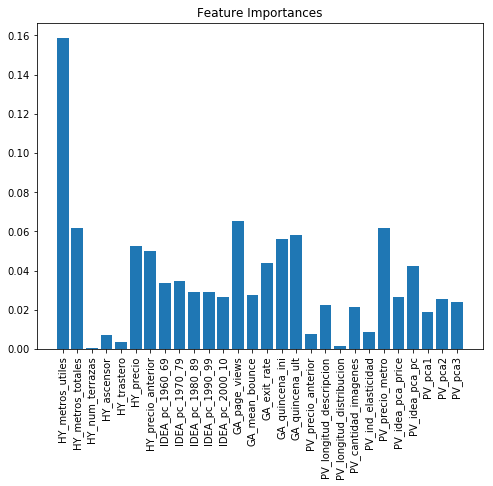

In [144]:
v = xgb_model.feature_importances_
plt.figure(figsize=(8,6))
plt.bar(range(len(v)), v)
plt.title('Feature Importances')
plt.xticks(range(len(X_train.columns)), list(X_train.columns), rotation = 90)
plt.show()

In [157]:
# Ordenamos las variables de menor a mayor
features_ordered, colnames_ordered = zip(*sorted(zip(xgb_model.feature_importances_, X_train.columns)))
# No tenemos en cuenta las 10 peores variables
EntrenarModelos(X, y, models, list(colnames_ordered[10:]))

BestXGBoost: 20.791393280029297


{'BestXGBoost': 20.791393280029297}

Por lo que el mejor modelo es el primer XGBoost entrenado

# Conjunto de Test

Realizamos las mismas transforaciones para test

In [182]:
df = pd.read_table('Estimar_UH2019.txt', sep = '|', dtype={'HY_cod_postal':str})
# Tenemos varios Nans en HY_provincias, por lo que creamos la siguiente función que nos ayudará a imputarlos con
#     ayuda del código postal
def ArreglarProvincias(df):
    # Diccionario de los códigos postales. 'xxddd' --> xx es el código asociado a la provincia
    diccionario_postal = {'02':'Albacete','03':'Alicante','04':'Almería','01':'Álava','33':'Asturias',
                          '05':'Avila','06':'Badajoz','07':'Baleares', '08':'Barcelona','48':'Bizkaia',
                          '09':'Burgos','10':'Cáceres','11':'Cádiz','39':'Cantabria','12':'Castellón',
                          '13':'Ciudad Real','14':'Córdoba','15':'A Coruña','16':'Cuenca','20':'Gipuzkoa',
                          '17':'Gerona','18':'Granada','19':'Guadalajara','21':'Huelva','22':'Huesca',
                          '23':'Jaén','24':'León','25':'Lérida','27':'Lugo','28':'Madrid','29':'Málaga',
                          '30':'Murcia','31':'Navarra','32':'Ourense','34':'Palencia','35':'Las Palmas',
                          '36':'Pontevedra','26':'La Rioja','37':'Salamanca','38':'Tenerife','40':'Segovia',
                          '41':'Sevilla','42':'Soria','43':'Tarragona','44':'Teruel','45':'Toledo','46':'Valencia',
                          '47':'Valladolid','49':'Zamora','50':'Zaragoza','51':'Ceuta','52':'Melilla'}
    
    # Obtenemos los códigos postales que nos faltan
    codigos_postales = df.loc[df.HY_provincia.isnull()].HY_cod_postal
    
    # Recorremos la pareja index, value
    for idx, cod in zip(codigos_postales.index, codigos_postales):
        # Del cod solo nos interesan los dos primeros valores para la provincia.
        df.loc[idx,'HY_provincia'] = diccionario_postal[cod[:2]]
        
    # Devolvemos el df de las provincias
    return df

# Obtenemos nuestro df con las provincias imputadas
df = ArreglarProvincias(df)


########## Metros ##############
# Volvemos Nans los valores de 0m^2 o inferior --> Los 0 provocan errores en una nueva variable de €/m2
df.loc[df['HY_metros_utiles'] <= 0,'HY_metros_utiles'] = np.nan
df.loc[df['HY_metros_totales'] <= 0,'HY_metros_totales'] = np.nan

# Obtenemos las posiciones de los valores faltantes en los metros útiles
posiciones_nans = df['HY_metros_totales'].isnull()
# Rellenamos los Nans con los metros totales
df.loc[posiciones_nans,'HY_metros_totales'] = df.loc[posiciones_nans,'HY_metros_utiles']

# Obtenemos las posiciones de los valores faltantes een los metros útiles
posiciones_nans = df['HY_metros_utiles'].isnull()
# Rellenamos los Nans con los metros totales
df.loc[posiciones_nans,'HY_metros_utiles'] = df.loc[posiciones_nans,'HY_metros_totales']

# Si continuamos teniendo Nans
if df[['HY_metros_utiles', 'HY_metros_totales']].isnull().sum().sum()>0: # Hay 2 .sum para sumarlo todo
    # Cuales son los indices de los registros que tienen nans
    index_nans = df.index[df['HY_metros_utiles'].isnull()]
    for i in index_nans:
        tipo = df.loc[i, 'HY_tipo']
        df.loc[i, ['HY_metros_utiles', 'HY_metros_totales']] = group_tipo.loc[tipo] # Recuperamos group_tipo
        

########## Precios ############
# Creamos una nueva variable que sea ¿Existe precio anterior?--> Si/No
df['PV_precio_anterior'] = df['HY_precio_anterior'].isnull()
# Y modificamos precio anterior para que tenga los valores del precio actual como anterior
df.loc[df['HY_precio_anterior'].isnull(),'HY_precio_anterior'] = df.loc[df['HY_precio_anterior'].isnull(),'HY_precio']


######## Descripción y distribución #########
# Creamos 2 nuevas variables con la longitud del texto expuesto (Nan = 0)
# Igualamos los NaN a carácteres vacíos
df.loc[df['HY_descripcion'].isnull(),'HY_descripcion'] = ''
df.loc[df['HY_distribucion'].isnull(),'HY_distribucion'] = ''
# Calculamos su longitud
df['PV_longitud_descripcion'] = df['HY_descripcion'].apply(lambda x: len(x))
df['PV_longitud_distribucion'] = df['HY_distribucion'].apply(lambda x: len(x))

####### Cantidad de imágenes #########
# Añadimos una nueva columna que es la cantidad de imágenes que tiene asociado el piso
# El df de información de las imágenes tiene 3 columnas: id, posicion_foto, carácteres_aleatorios
df_imagenes = pd.read_csv('df_info_imagenes.csv', sep = '|',encoding = 'utf-8')
# Realizamos un count de los ids de las imagenes (Y nos quedamos con el valor de la 
#      variable Posiciones (Al ser un count, nos es indiferente la variable seleccionada))
df_count_imagenes = df_imagenes.groupby('HY_id').count()['Posiciones']
# Definimos la función que asocia a cada id su número de imágenes
def AñadirCantidadImagenes(x):
    try:
        return df_count_imagenes.loc[x]
    except:
        return 0
# Creamos la variable
df['PV_cantidad_imagenes'] = df['HY_id'].apply(lambda x: AñadirCantidadImagenes(x))


######### Imputación de las variables IDEA #########
# En el notebook ImputacionNans.ipynb se explica en mayor profundidad las funciones definidas. Por el momento, 
#    para imputar los valores Nans de las variables IDEA realizamos lo siguiente:
#       -1. Hacemos la media de las variables que no son Nan por CP
#       -2. Imputamos por la media del CP
#       -3. Repetimos para aquellos codigos postales que son todo Nans con la media por provincias (Sin contar los imputados)
#       -4. Imputamos los Nans que faltan por la media general de todo (Sin contar los imputados)
var_list = [
    ['IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89','IDEA_pc_1990_99', 'IDEA_pc_2000_10'],
    ['IDEA_pc_comercio','IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros','IDEA_pc_residencial', 'IDEA_pc_trast_parking'],
    ['IDEA_ind_tienda', 'IDEA_ind_turismo', 'IDEA_ind_alimentacion'],
    ['IDEA_ind_riqueza'],
    ['IDEA_rent_alquiler'],
    ['IDEA_ind_elasticidad', 'IDEA_ind_liquidez'],
    ['IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential', 'IDEA_stock_sale_residential'],
    ['IDEA_demand_sale_residential'],
    ['IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential', 'IDEA_stock_rent_residential'],
    ['IDEA_demand_rent_residential']   
]

# Función para arregla los codigos postales mal leidos (Son leidos como enteros).
def ArreglarCP(cp):
    if len(cp)==4:
        return '0'+cp
    else:
        return cp
    
def ImputarNans_test(df, vars_imput, var):
    '''
    df --> Nuestro dataframe a modificar
    vars_imput --> Variables que queremos imputar.
    var --> Variable por la que queremos realizar la agrupación (HY_cod_postal ó HY_provincia)
    '''
    # Obtenemos nuestros df definidos durante el Train
    if var == 'HY_cod_postal':
        # Hay un error en la escritura del CP, ya que se guardó como int
        group_cp = pd.read_csv('./DF_grupos/group_cp_{}.csv'.format(vars_imput[0]), sep = '|', encoding='utf-8', dtype={'HY_cod_postal': str})
        group_cp['HY_cod_postal'] = group_cp['HY_cod_postal'].apply(lambda x: ArreglarCP(x))
        group_cp.index = group_cp['HY_cod_postal']
        group_cp = group_cp.drop('HY_cod_postal',axis = 1)
    elif var == 'HY_provincia':
        group_cp = pd.read_csv('./DF_grupos/group_prov_{}.csv'.format(vars_imput[0]), sep = '|', encoding='utf-8', index_col='HY_provincia')
    else:
        print('Solo se acepta HY_cod_postal ó HY_provincia como valor de "var"')
    
    # Obtenemos los CP que son Nans
    codigos_nans = df.loc[df[vars_imput[0]].isnull(), var] # Valdría cualquiera de las variables.
    
    # Como sabemos que códigos podremos completar y cuales no, solo utilizaremos los que se pueden completar
    cods = np.intersect1d(codigos_nans.unique(),group_cp.index)
    # Cuales son los índices de los Nans
    index_nan = df.index[df[vars_imput[0]].isnull()]
    for cod in cods:
        # Explicación del indexado: De todos los códigos que coinciden con el nuestro nos quedamos con los que tienen índice
        #      nan, y para poder acceder a df, necesitamos los índices de Nan que cumplen lo del código.
        i = index_nan[(df[var] == cod)[index_nan]]
        df.loc[i, vars_imput] = group_cp.loc[cod].values
    
    # Si ya hemos terminado de imputar y aún nos quedan Nans imputamos por la media de todo
    if var == 'HY_provincia' and df[vars_imput[0]].isnull().sum()>0:
        df.loc[df[vars_imput[0]].isnull(), vars_imput] = group_cp.mean(axis = 0).values
    
    # Devolvemos el dataframe imputado
    return df

# Como en el caso anterior, vamos conjunto por conjunto
for vars_group in var_list:
    df = ImputarNans_test(df, vars_group, var = 'HY_cod_postal')
    df = ImputarNans_test(df, vars_group, var = 'HY_provincia')

####### Indice elasticidad ##########
# Creamos una nueva variable que redondea el indice de elasticidad al entero más cercano (La variable toma 1,2,3,4,5)
df['PV_ind_elasticidad'] = np.round(df['IDEA_ind_elasticidad'])

###### Antigüedad zona #########
# Definimos la variable de antigüedad de la zona dependiendo del porcentaje de pisos construidos en la zona
# Primero tomaremos las variables [IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,
#          IDEA_pc_1990_99,IDEA_pc_2000_10] y las transformaremos en solo 3. Y luego nos quedaremos 
#          con el máximo de esas tres para determinar el estado de la zona.
df['Viejos'] = df[['IDEA_pc_1960', 'IDEA_pc_1960_69']].sum(axis = 1)
df['Medios'] = df[['IDEA_pc_1970_79', 'IDEA_pc_1980_89']].sum(axis = 1)
df['Nuevos'] = df[['IDEA_pc_1990_99', 'IDEA_pc_2000_10']].sum(axis = 1)
df['PV_clase_piso'] = df[['Viejos','Medios','Nuevos']].idxmax(axis = 1)

# Añadimos una nueva variable que es si la longitud de la descripción es nula, va de 0 a 1000 carácteres, ó supera los 1000
df['PV_longitud_descripcion2'] = pd.cut(df['PV_longitud_descripcion'], bins = [-1,0,1000, np.inf], labels=['Ninguna', 'Media', 'Larga'], include_lowest=False)

# Precio de euro el metro
df['PV_precio_metro'] = df.HY_precio/df.HY_metros_totales

# Cambiamos Provincias por 'Castellón','Murcia','Almería','Valencia','Otros'
def estructurar_provincias(x):
    '''
    Funcion que asocia a x (Nombre de provincia) su clase
    '''
    # Lista de clases que nos queremos quedar
    if x in ['Castellón','Murcia','Almería','Valencia']:
        return x
    else:
        return 'Otros'
df['PV_provincia'] = df.HY_provincia.apply(lambda x: estructurar_provincias(x))

# Una nueva que es si el  inmueble presenta alguna distribución
df.loc[df['PV_longitud_distribucion'] > 0,'PV_longitud_distribucion'] = 1

# Cambiamos certificado energetico a Si/No (1/0)
df['PV_cert_energ'] = df['HY_cert_energ'].apply(lambda x: np.sum(x != 'No'))

# Cambiamos las categorías de HY_tipo a solo 3: [Piso, Garaje, Otros]
def CategorizarHY_tipo(dato):
    if dato in ['Piso', 'Garaje']:
        return dato
    else:
        return 'Otros'
df['PV_tipo'] = df['HY_tipo'].apply(CategorizarHY_tipo)

# Cambiamos la variable Garaje a Tiene/No tiene (1/0)
df.loc[df['HY_num_garajes']>1,'HY_num_garajes'] = 1

# Cambiamos baños por 0, 1, +1 (No tiene, tiene 1, tiene mas de 1)
df['PV_num_banos'] = pd.cut(df['HY_num_banos'], [-1,0,1,np.inf], labels = [0,1,'+1'])

# Cambiamos Num terrazas a Si/No (1/0)
df.loc[df['HY_num_terrazas']>1, 'HY_num_terrazas'] = 1


# Definimos las variables a eliminar para definir nuestro conjunto X
drop_vars = ['HY_id', 'HY_cod_postal', 'HY_provincia', 'HY_descripcion',
             'HY_distribucion', 'HY_tipo', 'HY_antiguedad','HY_num_banos', 'HY_cert_energ',
             'HY_num_garajes', 'IDEA_pc_1960', 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad', 'IDEA_ind_elasticidad',
             'Viejos', 'Medios','Nuevos']
# Explicación:
# + 'HY_id', 'HY_cod_postal' --> Demasiadas categorías
# + 'HY_provincia' --> Ya tenemos PV_provincia que las agrupa
# + 'HY_descripcion','HY_distribucion' --> Tenemos sus longitudes
# + 'HY_tipo' --> Ya hemos creado PV_tipo
# + 'HY_cert_energ','HY_num_garajes'--> Ya tenemos las PV asociadas (valores con 0 1)
# + 'IDEA_pc_1960' --> Está duplicada
# + 'IDEA_area', 'IDEA_poblacion', 'IDEA_densidad' --> Demasiados Nans
# + 'IDEA_ind_elasticidad' --> Tenemos la variable equivalente en PV
# + 'Viejos', 'Medios','Nuevos' --> Ya tenemos PV_clase_piso

X_real_test = df.copy().drop(drop_vars, axis = 1)

# Definimos las variables como en Train
cont_vars = ['HY_metros_utiles', 'HY_metros_totales','GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult','PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro']

# Creamos las variables Dummy para las categóricas
dummy_vars = ['PV_provincia','PV_longitud_descripcion2',
              'PV_clase_piso','PV_tipo','PV_num_banos']
# Unimos nuestro conjunto con el de dummies
X_real_test = X_real_test.join(pd.get_dummies(X_real_test[dummy_vars]))
# Eliminamos las variables que ya son Dummies
X_real_test = X_real_test.drop(dummy_vars, axis=1)


############# PCA ####################
# Realizamos una PCA con las variables IDEA
idea_vars_price = [
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential']
idea_pca_price = pca_prices.transform(X_real_test[idea_vars_price])
X_real_test['PV_idea_pca_price'] = (idea_pca_price-idea_pca_price.min())/(idea_pca_price.max()-idea_pca_price.min())
# Realizamos una PCA con las variables IDEA 
idea_vars_pc = [
       'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez']

idea_pca_pc = pca_pc.transform(X_real_test[idea_vars_pc])
X_real_test['PV_idea_pca_pc'] = (idea_pca_pc-idea_pca_pc.min())/(idea_pca_pc.max()-idea_pca_pc.min())
# Nos quedamos con la información PCA de nuestras PV 
PV_pca = pca_PV.transform(X_real_test[['PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1']])

X_real_test['PV_pca1'] = PV_pca[:, 0]
X_real_test['PV_pca2'] = PV_pca[:, 1]
X_real_test['PV_pca3'] = PV_pca[:, 2]

# Eliminamos las variables que ya no queremos
X_real_test = X_real_test.drop([
       'IDEA_unitprice_sale_residential', 'IDEA_price_sale_residential',
       'IDEA_stock_sale_residential', 'IDEA_demand_sale_residential',
       'IDEA_unitprice_rent_residential', 'IDEA_price_rent_residential',
       'IDEA_stock_rent_residential', 'IDEA_demand_rent_residential',
       'IDEA_pc_comercio',
       'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros',
       'IDEA_pc_residencial', 'IDEA_pc_trast_parking', 'IDEA_ind_tienda',
       'IDEA_ind_turismo', 'IDEA_ind_alimentacion', 'IDEA_ind_riqueza',
       'IDEA_rent_alquiler', 'IDEA_ind_liquidez', 'PV_cert_energ',
       'PV_provincia_Almería', 'PV_provincia_Castellón', 'PV_provincia_Murcia',
       'PV_provincia_Otros', 'PV_provincia_Valencia',
       'PV_longitud_descripcion2_Larga', 'PV_longitud_descripcion2_Media',
       'PV_longitud_descripcion2_Ninguna', 'PV_clase_piso_Medios',
       'PV_clase_piso_Nuevos', 'PV_clase_piso_Viejos', 'PV_tipo_Garaje',
       'PV_tipo_Otros', 'PV_tipo_Piso', 'PV_num_banos_0', 'PV_num_banos_1',
       'PV_num_banos_+1'], axis = 1)

array(['GA_exit_rate', 'GA_mean_bounce', 'GA_page_views',
       'GA_quincena_ini', 'GA_quincena_ult', 'HY_ascensor',
       'HY_metros_totales', 'HY_metros_utiles', 'HY_num_terrazas',
       'HY_precio', 'HY_precio_anterior', 'HY_trastero',
       'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'PV_cantidad_imagenes',
       'PV_idea_pca_pc', 'PV_idea_pca_price', 'PV_ind_elasticidad',
       'PV_longitud_descripcion', 'PV_longitud_distribucion', 'PV_pca1',
       'PV_pca2', 'PV_pca3', 'PV_precio_anterior', 'PV_precio_metro'],
      dtype=object)

In [186]:
X_real_test.columns

Index(['HY_metros_utiles', 'HY_metros_totales', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_precio', 'HY_precio_anterior',
       'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
       'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'GA_page_views', 'GA_mean_bounce',
       'GA_exit_rate', 'GA_quincena_ini', 'GA_quincena_ult',
       'PV_precio_anterior', 'PV_longitud_descripcion',
       'PV_longitud_distribucion', 'PV_cantidad_imagenes',
       'PV_ind_elasticidad', 'PV_precio_metro', 'PV_idea_pca_price',
       'PV_idea_pca_pc', 'PV_pca1', 'PV_pca2', 'PV_pca3'],
      dtype='object')

In [194]:
# Realizamos la predicción
y_final_pred = xgb_model.predict(X_real_test)
# Deshacemos el cambio
ultra_final_pred = np.exp(y_final_pred)-1
# Guardamos el resultado

# Definimos el df de solución aprovechando que tenemos el HY_id almacenado en df
df_solucion = pd.DataFrame({'HY_id':df['HY_id'], 'TM_Est':ultra_final_pred})
df_solucion.head(7)
# Guardamos la solución
df_solucion.to_csv('machine predictor_UH2019.txt', 
                   header=True, index=False, sep='|', encoding='utf-8')